# Introduction

In this notebook we will analyze the [Census Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) from UCI Machine Learning Repository.  

The dataset contains three files: 


*   [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) - training set
*   [adult.names](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names) - dataset description
*   [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test) - test set 


The data contains anonymous information such as age, occupation, education, working class, etc. The goal is to train a binary classifier to predict the income which has two possible values '>50K' and '<50K'. There are 48842 instances and 14 attributes in the dataset. The data contains a good blend of categorical, numerical and missing values. 

We will use **Logistic Regression** to train our model





# 1. Importing Libraries

In [54]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from pandas.api.types import CategoricalDtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

%matplotlib inline

# Loading Data

*   The train and test dataset doesn't come with the column names by default. Hence we assign the column names manually
*   There are ceratain instances where there are  whitespaces before and after the data values. You can pass a regex to the **sep** paramter to the pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function. We will use the separator as \* , *

*   The missing values in the dataset are indicated by **'?'**. We will use **na_values** parameter to indicate the missing values 
*   The test dataset contains some weird first row, hence we will use **skiprows=1** to skip the first row




In [55]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv(r'..\data\general_dfs\adult.data', names = columns, sep=' *, *', na_values='?',engine='python')
test_data = pd.read_csv(r'..\data\general_dfs\adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?',engine='python')

Let's look at the first 5 rows of the training data

In [56]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Similarly, we look at the first 5 rows of the test dataset

In [57]:
test_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


Both the train and the test dataset contains the predictor variable '**income**'. This needs to be removed before the data is passed to a machine-learning model

In [58]:
train_data_1 = train_data
test_data_1 = test_data

In [59]:
train_data_1 = train_data_1.drop('income', axis= 1)
test_data_1 = test_data_1.drop('income', axis= 1)

In [60]:
train_data.columns

Index(['age', 'workClass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

# Exploratory Data Analysis

## Cleaning the data

Let's look for any missing values in both the train and the test dataset. We need to fill/remove these values 

In [61]:
def null_count (df):
    """
                        ---What it does---
    Identifies and counts the number of null values in any given df. Does not return anything.

                        ---What it needs---
    A DataFrame
    """
    null_in_df = df.isnull().any()
    is_null = df.isnull().sum()
    print (f'Presence of null in clolumns:\n{null_in_df}\n\nNumber of null in columns:\n{is_null}')

In [62]:
null_count(train_data_1)

Presence of null in clolumns:
age               False
workClass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
dtype: bool

Number of null in columns:
age                  0
workClass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
dtype: int64


In [63]:
null_count(test_data_1)

Presence of null in clolumns:
age               False
workClass          True
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
dtype: bool

Number of null in columns:
age                 0
workClass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64


**Observations on the train dataset**

*  See what is the number of samples in the train data set
*  There are both categorical and numerical attributes in the dataset
*  Which columns have missing values?



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workClass         15318 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education-num     16281 non-null int64
marital-status    16281 non-null object
occupation        15315 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16007 non-null object
income            16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


**Observations on the test dataset**

*  See what is the number of samples in the test data set
*  Is ther any columns with missing values?

In [64]:
train = train_data_1.dropna()
test = test_data_1.dropna()

## Handing Numerical Attributes

We will select all the numerical attributes from the dataset using [select_dtypes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html) function from the pandas dataframe library 

In [65]:
train_num = train.select_dtypes(exclude= 'object')
train_cat = train.select_dtypes(exclude= 'int64')
train_num.columns

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

The variables **age**, **hours-per-week** are self-explanatory. 


*   **fnlwgt**: sampling weight
*  ** education-num**: number of years of education in total
* **capital-gain/capital-loss**: income from investment sources other than salary/wages

fnlwgt is not related to the target variable **income** and will be removed before building the model



**Data Visualizations**

Plot histograms of the numerical values

In [66]:
columns = list(train_num.columns)
columns

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

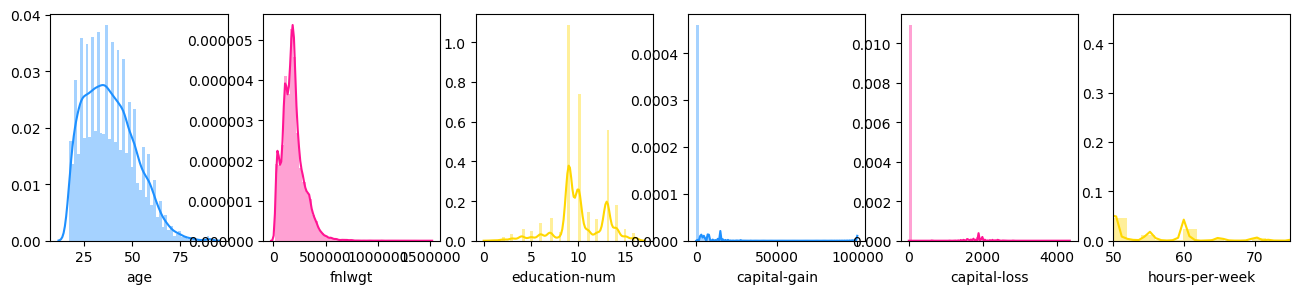

In [67]:
fig, axes = plt.subplots(1, 6, figsize=(16, 3), dpi=100)

x1 = train_num[columns[0]]
x2 = train_num[columns[1]]
x3 = train_num[columns[2]]
x4 = train_num[columns[3]]
x5 = train_num[columns[4]]
x6 = train_num[columns[5]]


sns.distplot(x1 , color="dodgerblue", ax=axes[0], axlabel=columns[0])
sns.distplot(x2 , color="deeppink", ax=axes[1], axlabel=columns[1])
sns.distplot(x3 , color="gold", ax=axes[2], axlabel=columns[2])
sns.distplot(x4 , color="dodgerblue", ax=axes[3], axlabel=columns[3])
sns.distplot(x5 , color="deeppink", ax=axes[4], axlabel=columns[4])
sns.distplot(x6 , color="gold", ax=axes[5], axlabel=columns[5])

plt.xlim(50,75);

Use describe to understand the numerical attributes


In [68]:
train_num.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**Observations**

* None of the numerical attributes have missing values 
* The values are on different scales. Many machine learning models require the features to be on the same scale. 
* We can see that there are many outliers present in the data, we will use [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from sklearn library

## Handling Categorical Attributes
We will select all the categorical attributes from the dataset using [select_dtypes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.select_dtypes.html) function from the pandas dataframe library. Remember categorical variables are stored as Object type in Pandas 


In [69]:
train_cat.columns

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

**Data-visualizations**

Visualize the workclass types with a seaborn countplot using 'income' as hue.

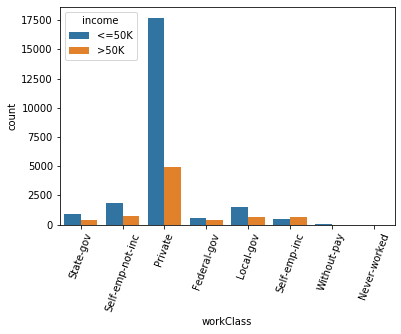

In [70]:
sns.countplot(x = 'workClass', data = train_data, hue= 'income')
plt.xticks(rotation = 70);

Visualize the occupation types with a seaborn countplot using 'income' as hue.

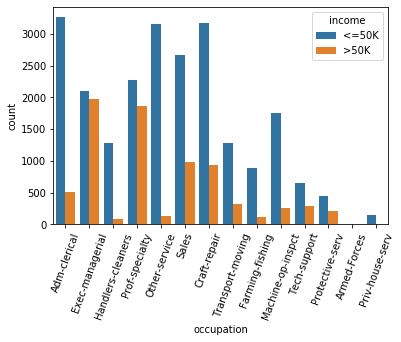

In [71]:
sns.countplot(x = 'occupation', data = train_data, hue= 'income')
plt.xticks(rotation = 70);

**Observations**

* All the variables are self-explanatory. 
* The column **education** is just a string representation of the column  **education-num**. We will drop the **education** column 
* The variables **workClass**, **occupation**, **native-country** have missing values. We will replace the missing values in each column with the **most_frequent** occurring value of that column.







We need to handle the numerical and categorical attributes differently.  Numerical attributes needs to be scaled, where as we need to fill the missing values and then encode the categorical values into numerical values.  To apply these sequence of transformations we will use the sklearn [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).  We will also build custom transformers that can be directly used with Pipeline

# Creating Pipelines

sklearn has many in-built transformers. However, if the in-built ones doesn't get the job done for you, you can build a custom transformer. All you need to do is to inherit [BaseEstimator](http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html) and [TransformerMixin](http://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) classes. You also need to implement the **fit** and **transform** methods. 
* **fit** - should return an instance of self and you can add the logic in 
* **transform** - add the logic here.

## ColumnSelector Pipeline


In [72]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
        from sklearn.pipeline import Pipeline

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


num_pipeline = Pipeline([("select_numeric", DataFrameSelector(train_data_1.select_dtypes(exclude= 'object'))), ("imputer", SimpleImputer(strategy="median"))])


cat_pipeline = Pipeline([("select_cat", DataFrameSelector(train_data_1.select_dtypes(exclude= 'int64'))), ("imputer", MostFrequentImputer()),("cat_encoder", OneHotEncoder(sparse=False))])

sklearn doesn't provide libraries to directly manipulate with pandas dataframe. We will write our own Custom Transformer which will select the corresponding attributes (either numerical or categorical)

Create a ColumnsSelector class that does this work.


In [73]:
num_pipeline

Pipeline(memory=None,
         steps=[('select_numeric',
                 DataFrameSelector(attribute_names=       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0       39   77516             13          2174             0              40
1       50   83311             13             0             0              13
2       38  215646              9             0             0              40
3       53  234721              7             0             0              40
4       28  338409             13             0             0              40
...    ...     ...            ...           ...           ...             ...
32556   27  257302             12             0             0              38
32557   40  154374              9             0             0              40
32558   58  151910              9             0             0              40
32559   22  201490              9             0             0              20
32560   52  287927              9 

## Numerical Data Pipeline

For the numerical data we create a numerical_pipeline. We select the numerical attributes using the **ColumnsSelector** transformer defined above and then scale the values using the Standard Scaler included in

## Categorical Data Pipeline

### Handling missing values

We need to replace the missing values in the categorical columns. We will replace the missing values with the most frequently occuring value in each column.  sklearn comes with [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html#) to handle missing values. However,  **Imputer** works only with numerical values. We will write a custom transformer which will accept a list of columns for which you need to replace the missing values and the strategy used to fill the missing values.

Let't buid this CategoricalImputer.


In [74]:
cat_pipeline

Pipeline(memory=None,
         steps=[('select_cat',
                 DataFrameSelector(attribute_names=              workClass   education      marital-status         occupation  \
0             State-gov   Bachelors       Never-married       Adm-clerical   
1      Self-emp-not-inc   Bachelors  Married-civ-spouse    Exec-managerial   
2               Private     HS-grad            Divorced  Handlers-cleaners   
3               Private        11th  Married-civ-spouse  Handlers-cleaners   
4               Private   Bachelors  Married-civ-spouse     Prof-s...
32557        Husband  White    Male  United-States  
32558      Unmarried  White  Female  United-States  
32559      Own-child  White    Male  United-States  
32560           Wife  White  Female  United-States  

[32561 rows x 8 columns])),
                ('imputer', MostFrequentImputer()),
                ('cat_encoder',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=

### Encoding categorical values to numerical 

All the machine learning models expects numerical values. We need to convert the categorical columns to numerical values. We will use [pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html). This is similar to using [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) except that OneHotEncoder requires numerical columns. 

\\

We need to merge the train and test dataset before using pd.get_dummies as there might be classes in the test dataset that might not be present in the training dataset. But, we need to pass only the encoded train data to further transformers in the pipeline when we train the model. For this in the fit method we will concatenate the train and test dataset and find out all the possible values for a column. In the transform method, when we pass either the train dataset, we will convert each column to [Categorical](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.api.types.CategoricalDtype.html) Type and specify the list of categories that the column can take. pd.get_dummies will create an column of all zeros for the category not present in the list of categories.

\\

The transformer also takes an argument **dropFirst** which indicates whether we should drop the first column after creating dummy columns using pd.get_dummies. By default, the value is set to **True**

In [75]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)
 

We create our pipeline for handling the categorical attributes. First transformer is to select the categorical attributed from the dataframe and then we replace the missing values and then encode the categorical features to numerical features.

### Complete Categorical Pipeline

In [76]:
cat_pipeline = CategoricalEncoder(cat_pipeline)

We select the categorical attributes using the **ColumnsSelector** transformer we defined above. The missing values are replaced by the **CategoricalImputer** pipeline and finally we encode the categorical values to numerical values using the **CategoricalEncoder** transformer. 

In [77]:
cat_pipeline

CategoricalEncoder(dropFirst=Pipeline(memory=None,
                                      steps=[('select_cat',
                                              DataFrameSelector(attribute_names=              workClass   education      marital-status         occupation  \
0             State-gov   Bachelors       Never-married       Adm-clerical   
1      Self-emp-not-inc   Bachelors  Married-civ-spouse    Exec-managerial   
2               Private     HS-grad            Divorced  Handlers-cleaners   
3               Private        11th  Married-civ-spouse  Handlers-cleaners   
4               Private   Bach...
32557        Husband  White    Male  United-States  
32558      Unmarried  White  Female  United-States  
32559      Own-child  White    Male  United-States  
32560           Wife  White  Female  United-States  

[32561 rows x 8 columns])),
                                             ('imputer', MostFrequentImputer()),
                                             ('cat_encoder',
  

## Complete Pipeline

We have two transformer pipeline i.e, **num_pipeline** and **cat_pipeline**. We can merge them using  [FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html).

In [78]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),("cat_pipeline", cat_pipeline),])

# Building the Model

We now have all the pipelines for preprocessing our data, next step is to prepare the data to be passed to the model.  Let's drop 'fnlwgt' and 'education' from train_data and test_data

In [79]:
preprocess_pipeline

FeatureUnion(n_jobs=None,
             transformer_list=[('num_pipeline',
                                Pipeline(memory=None,
                                         steps=[('select_numeric',
                                                 DataFrameSelector(attribute_names=       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0       39   77516             13          2174             0              40
1       50   83311             13             0             0              13
2       38  215646              9             0             0              40
3       53  234721              7             0             0              40
4       28  338409             13             0             0              40
...    ...     ...            ...           ...           ...             ...
32556   27  257302             12             0             0              38
32557   40  154374              9             0             0              40
32558   58  151910  

In [80]:
train_data =  train_data.drop(['fnlwgt', 'education'], axis = 1)
test_data =  test_data.drop(['fnlwgt', 'education'], axis = 1)

## Preparing the data for training

In [81]:
# copy the data before preprocessing

# convert the income column to 0 or 1 and then drop the column for the feature vectors

# creating the feature vector 


# target values



In [82]:
train_data['income'] = (train_data['income'] == '<=50K').astype(np.int_)

In [83]:
train_data.income.value_counts()

1    24720
0     7841
Name: income, dtype: int64

## Training the model

In [84]:
# pass the data through the full_pipeline


In [85]:
# Create a LogisticRegression model and train it
X_train = preprocess_pipeline.fit_transform(train_data)
X_train


ValueError: Must pass DataFrame with boolean values only

In [86]:
#show the coefficients of the model


# Testing the model

We need to use the same pipeline for preprocessing the test data set before testing the model

In [87]:
# take a copy of the test data set


# convert the income column to 0 or 1


# separating the feature vecotrs and the target values


In [88]:
# preprocess the test data using the full pipeline



In [89]:
# Predict the classes on the procesed data



# Model Evaluation

**We will use [accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) from sklearn to find the accuracy of the model** 

**Let's plot the [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)**

**Interpretation**

* Y-axis represents the actual classes
* X-axis represents the predicted classes
* **_** times when the model correctly predicted 0 when the actual class was 0 (**True Negatives**)
* **_** times the model  predicted 0 when the actual class was 1 (**False Negatives**)
* **_** times the model  predicted 1 when the actual class was 0 (**False Positives**)
* **_** times the model correctly predicted 1 when the actual class was 1 (**True Positives**) 

# Cross Validation

We will use [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to divide our dataset into k folds. In each iteration, k-1 folds are used as training set and the remaining is used as the training set to validate the model. We use StratifiedKFold because it preserves the percentage of samples of each class. 

\\

If we use [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), we might run the risk of introducing sampling bias i.e, the train set might contain a large  number of samples where income is greater than 50K and the test set contains more samples where income is less than 50K. In this case, the model build from training data will not generalize well for test dataset. Whereas StratifiedKFold will ensure that there are enough samples of each class in both the train and test dataset.

We will use [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from the sklearn library to compute scores for each cross-validation. The parameter **cv** determines the cross-validation folds.

In [90]:
# create a cross validation model with the logistic regressor 
# find the scores from running the model using 5 folds



# Print the scores and the mean of them


# Fine Tuning the Model

By default Logistic Regression takes the below parameters

LogisticRegression(**C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False**)
          
We can fine-tune our model by playing around with the parameters. sklearn comes with [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to do an exhaustive search
over specified parameter values for an estimator.
          

Creating the hyperparameter space

In [91]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
random_state=[0]

# creating a dictionary of hyperparameters
hyperparameters = dict(C=C, penalty=penalty, random_state=random_state)

**Use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  to find the optimal parameters**

In [92]:
#Get the best_model

#print the penalty and c for the best model


**Predict the categories using the best model parameters**

[0 0 0 ... 1 0 1]


**Calculate the acurracy for the new model**

# Saving the model to pickle


We have done all the hard work of creating and testing the model. It would be good if we could save the model for future uses rather than retrain it. We will save our model in the [pickle](https://docs.python.org/2/library/pickle.html). 

In [93]:
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

NameError: name 'model' is not defined

Loading the model from pickle

In [94]:
saved_model = pickle.load(open(filename, 'rb')) 
print(saved_model)

FileNotFoundError: [Errno 2] No such file or directory: 'final_model.sav'

Now you can predict using the saved model. 